# 1. Giới thiệu
# Ứng dụng học máy dự đoán điểm thi kết thúc môn học của sinh viên

## Mục tiêu:
Mục tiêu của dự án này là dự đoán điểm thi cuối khóa (final) dưới dạng giá trị thực khi biết điểm của các bài kiểm tra trước đó, bao gồm:
- Course Work 1 (cw1): điểm bài kiểm tra số 1.
- Mid-term (mid-term): điểm bài kiểm tra giữa kì.
- Course Work 2 (cw2): điểm bài kiểm tra số 2.

Các bài kiểm tra được thực hiện theo trình tự: cw1 -> mid-term -> cw2 -> final.

Chúng tôi sẽ sử dụng 2 thuật toán hồi quy khác nhau để xây dựng các mô hình và so sánh hiệu suất của chúng nhằm chọn ra mô hình dự đoán tốt nhất.



#2. Đọc dữ liệu

In [1]:
#import các thư viện
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/grade-records_processed.csv')

# Xem một vài dòng dữ liệu
data.head()

,cw1,mid-term,cw2,final
0,5.9,4.9,7.8,6.6
1,6.8,7.5,6.6,7.5
2,6.7,9.8,4.2,4.4
3,6.5,6.5,5.5,4.5
4,6.5,6.5,5.4,5.4


#3. Kiểm tra tổng quan dữ liệu

In [2]:
# Kiểm tra thông tin về dữ liệu
data.info()

# Xem thống kê mô tả cơ bản của dữ liệu
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cw1       1029 non-null   float64
 1   mid-term  1029 non-null   float64
 2   cw2       1029 non-null   float64
 3   final     1029 non-null   float64
dtypes: float64(4)
memory usage: 32.3 KB


,cw1,mid-term,cw2,final
count,1029.000000,1029.000000,1029.000000,1029.000000
mean,6.513897,6.637221,6.590865,6.478231
std,1.775463,1.646091,1.310105,1.408290
min,3.000000,3.200000,3.300000,4.200000
25%,4.900000,5.300000,5.400000,5.200000
50%,6.500000,6.500000,6.600000,6.500000
75%,7.800000,7.800000,7.700000,7.500000
max,10.000000,10.000000,10.000000,9.700000


**Nhận xét:**
- Dữ liệu đã được đưa về dưới dạng số thực.
- Dữ liệu đã được chuẩn hóa về thang điểm 10.
- Có tất cả 1029 bản ghi dữ liệu.


#4. Kiểm tra dữ liệu thiếu

In [3]:
# Kiểm tra dữ liệu thiếu
missing_data = data.isnull().sum()
missing_data[missing_data > 0]

,0


**Nhận xét:**
- Ta thấy không có bản ghi nào thiếu dữ liệu trong tập dữ liệu.

#5. Phân phối dữ liệu

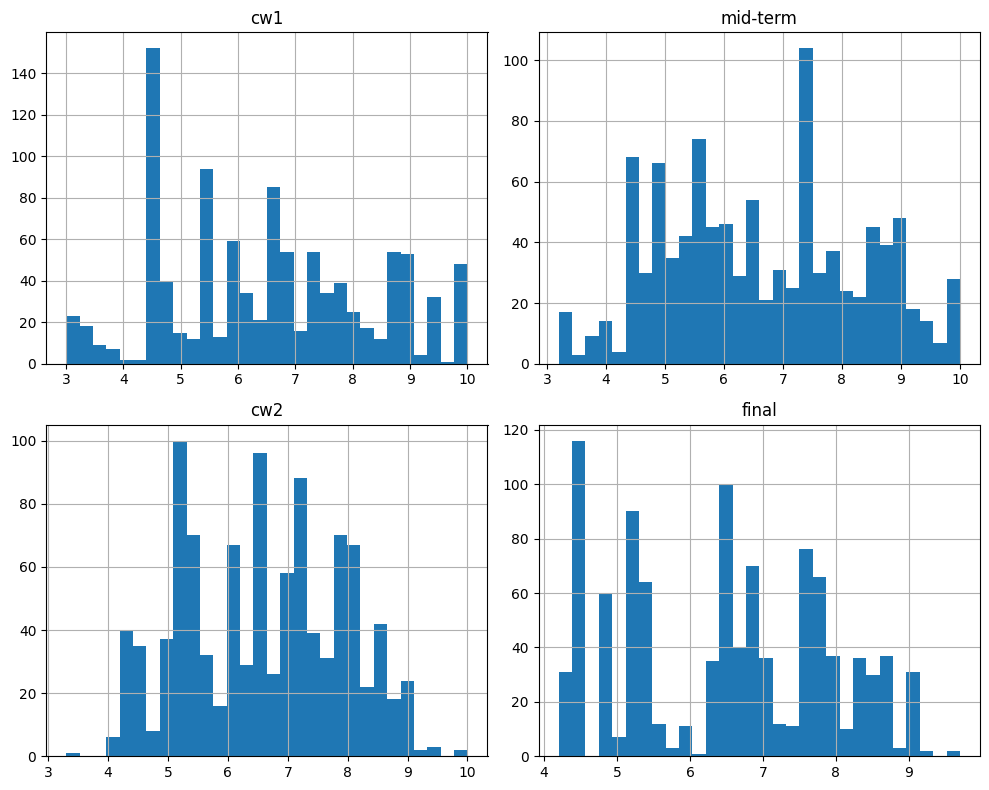

In [4]:
# Vẽ histogram cho mỗi biến
data.hist(figsize=(10, 8), bins=30)
plt.tight_layout()
plt.show()

**Nhận xét:**
- **cw1:** Phân phối lệch, đa số sinh viên đạt điểm từ 5 đến 7. Vậy điểm số cho bài tập này tập trung ở mức trung bình, không có nhiều sinh viên đạt điểm quá thấp hoặc quá cao.
- **cw2:** Có phân phối lệch tương tự, nhưng số lượng sinh viên đạt điểm cao nhiều hơn so với cw1.
- **mid-term:** Phân phối khá cân đối, số lượng sinh viên đạt điểm trung bình khá lớn, cho thấy sự cân bằng trong đánh giá khả năng của sinh viên ở kỳ thi này.
- **final:** Có sự phân tán khá rộng, một số sinh viên đạt điểm rất cao và một số đạt điểm rất thấp, dữ liệu có độ biến thiên khá lớn.

Các biến này không tuân theo phân phối chuẩn, có thể ảnh hưởng đến các mô hình yêu cầu dữ liệu chuẩn.

#6. Ma trận tương quan

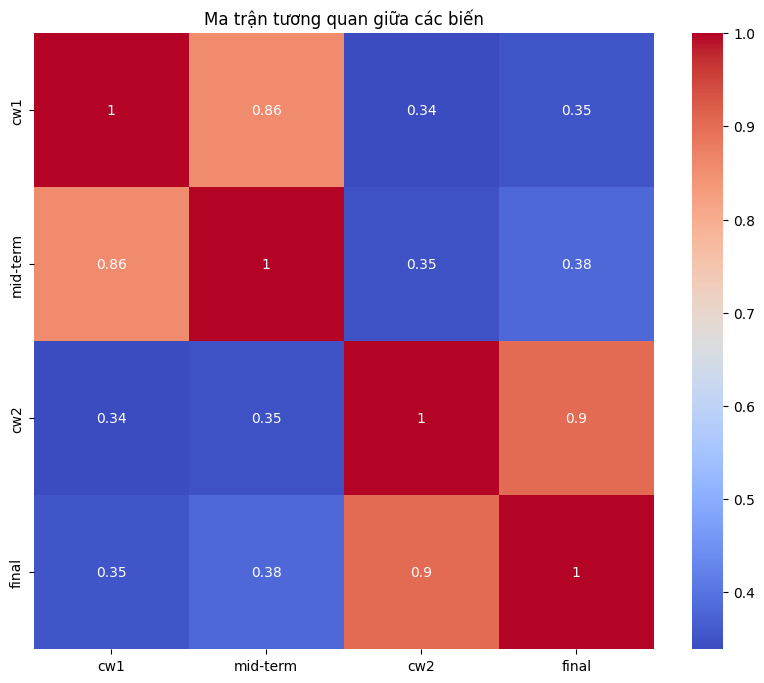

In [5]:
# Vẽ heatmap để xem mối tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(data[['cw1', 'mid-term', 'cw2', 'final']].corr(), annot=True, cmap='coolwarm')
plt.title('Ma trận tương quan giữa các biến')
plt.show()

**Nhận xét:**
- **cw1 và cw2:** mối tương quan dương nhẹ, tức là sinh viên đạt điểm cao ở cw1 có thể cũng đạt điểm cao ở cw2, nhưng không phải lúc nào cũng vậy.
- **mid-term và cw1:** Mối tương quan cao, có thể do thời gian giữa 2 bài kiểm tra này sát nhau hơn các bài kiểm tra khác.
- **mid-term và cw2:** Mối tương quan giữa điểm giữa kỳ và bài tập không quá mạnh, có thể các yếu tố đánh giá trong 2 bài kiểm tra này khác nhau và đánh giá các khía cạnh khác nhau của kiến thức sinh viên.
- **cw2 và final:** Mối tương quan mạnh nhất xuất hiện giữa cw2 và final, vậy điểm số cao ở bài tập thứ hai thường dẫn đến điểm thi cuối kỳ cao.

Ta thấy ***cw2*** có mối tương quan rất mạnh với ***final*** ( khoảng 0.9) cho thấy đây là một biến quan trọng trong việc dự đoán điểm cuối kỳ. Biến này có thể cần được chú ý khi chọn thuộc tính dự đoán.

#7. Boxplot để tìm outliers

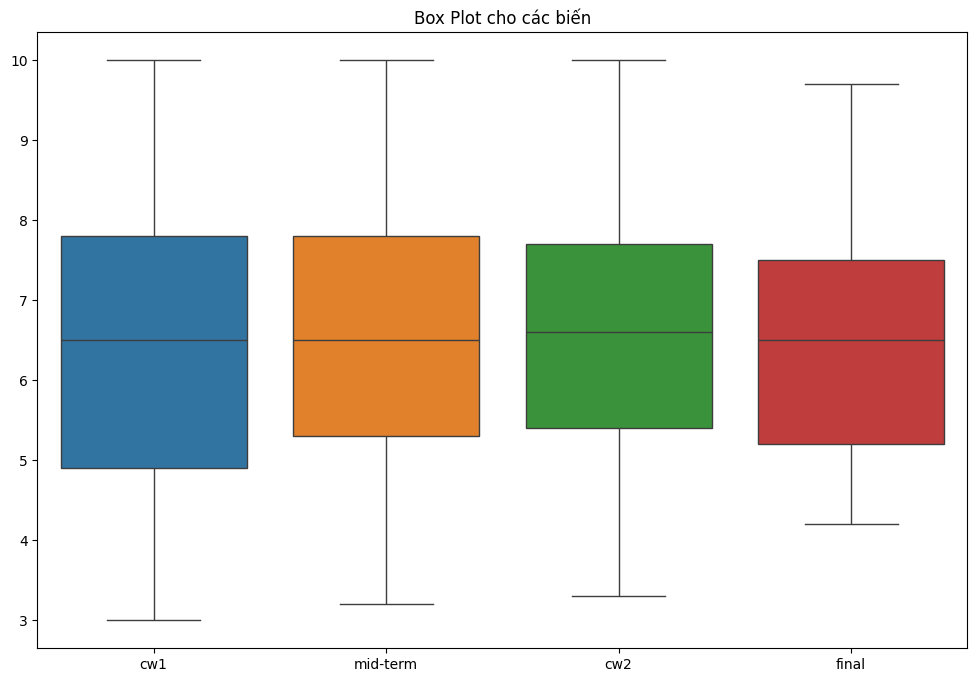

In [16]:
# Vẽ box plot cho các biến cụ thể
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plt.figure(figsize=(12, 8))
sns.boxplot(data=data[['cw1', 'mid-term', 'cw2', 'final']])
plt.title('Box Plot cho các biến')
plt.show()

**Nhận xét:**
- ***cw1*** và ***mid-term*** có phân bố tương tự nhưng ít quan trọng hơn trong việc dự đoán ***final***, dựa trên phân tích cả heatmap và boxplot.
- ***cw2*** có xu hướng điểm cao và ít biến động hơn, phù hợp với mối quan hệ mạnh mẽ với ***final***.
- Các boxplot đều cho thấy các biến không có nhiều giá trị ngoại lệ, tức là dữ liệu khá sạch và không có nhiều giá trị bất thường.

#8. Lựa chọn mô hình

**Nhận xét tổng quan:**
- Dữ liệu không tuân theo phân phối chuẩn, có độ biến thiên lớn ở biến mục tiêu ***final***, và có mối tương quan yếu giữa một số biến với biến mục tiêu.
- Có mối tương quan mạnh mẽ giữa ***cw2*** và ***final***.
- Một số biến như ***mid-term*** và ***cw1*** cũng thể hiện mối tương quan khá lớn.

Vậy, mô hình đơn giản như Linear Regression có vẻ không phù hợp trong trường hợp này, vì sự phân tán lớn của biến mục tiêu cũng như mối tương quan của mạnh một số biến có thể dẫn đến overfitting.

Xem xét sử dụng regularization trong trường hợp này có thể hợp lý. Chúng tôi đã xem xét mô hình Ridge Regression và Lasso Regression, là hai loại phổ biến nhất, và nhận thấy rằng Ridge Regression phù hợp hơn, do: Ridge Regression sẽ giúp giảm tác động của multicollinearity (tương quan tuyến tính giữa các biến) bằng cách làm giảm giá trị và phân bổ  các trọng số mà không *hoàn toàn loại bỏ* đi những thuộc tính có tương quan yếu (điều mà Lasso có thể sẽ làm).

Trong trường hợp này, chúng tôi muốn giữ nhận định rằng điểm các bài kiểm tra đều có vai trò đóng góp đối với ***final*** (dù mức độ đóng góp khác nhau).


- Sử dụng các mô hình có khả năng linh hoạt như Decision Tree để xử lý các yếu tố phi tuyến tính và phân phối không đồng đều của dữ liệu cũng có thể là lựa chọn tốt.

**Tổng kết:**
- Xem xét trên khả năng hiện tại của đội nhóm cùng các yếu tố về thời gian khác, chúng tôi quyết định sử dụng 2 mô hình là: ***Ridge Regression*** và ***Decision Tree***.


- Đồng thời, do sự biến thiên lớn của biến mục tiêu, chúng tôi sử dụng **K-fold cross-validation** để đảm bảo rằng mô hình không bị overfitting và có thể tổng quát hóa trên các tập dữ liệu chưa thấy.


#9. Chia dữ liệu thành tập huấn luyện và kiểm tra

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Chuẩn bị biến đầu vào (X) và đầu ra (y)
X = data[['cw1', 'mid-term', 'cw2']]  # Chọn các biến đầu vào
y = data['final']                      # Biến đầu ra

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# In ra kích thước của các tập dữ liệu
print(f'Size of training set: {X_train.shape[0]}')
print(f'Size of test set: {X_test.shape[0]}')

Size of training set: 823
Size of test set: 206


In [9]:
# Kiểm tra các phần tử đầu tiên của tập huấn luyện và kiểm tra
print("Training set features:")
print(X_train.head())

print("\nTraining set target:")
print(y_train.head())

print("\nTest set features:")
print(X_test.head())

print("\nTest set target:")
print(y_test.head())


Training set features:
     cw1  mid-term  cw2
404  7.3       6.4  7.1
988  5.7       9.8  4.2
522  4.9       5.5  7.8
482  7.9       7.5  9.0
445  9.0       8.1  7.8

Training set target:
404    6.8
988    4.4
522    7.9
482    8.8
445    6.3
Name: final, dtype: float64

Test set features:
     cw1  mid-term  cw2
290  6.0       5.3  6.0
534  9.6       8.9  8.5
261  6.0       5.3  6.9
107  8.7       8.6  7.7
425  5.5       6.7  6.9

Test set target:
290    6.6
534    8.7
261    6.6
107    7.5
425    7.0
Name: final, dtype: float64


In [13]:
# Lưu tập huấn luyện
train_data = pd.DataFrame(X_train)
train_data['final'] = y_train  # Thêm biến đầu ra vào tập huấn luyện
train_data.to_csv('/content/train_data.csv', index=False)

# Lưu tập kiểm tra
test_data = pd.DataFrame(X_test)
test_data['final'] = y_test  # Thêm biến đầu ra vào tập kiểm tra
test_data.to_csv('/content/test_data.csv', index=False)

print("Train and test datasets saved as 'train_data.csv' and 'test_data.csv'.")

Train and test datasets saved as 'train_data.csv' and 'test_data.csv'.


#10. Thiết lập K-fold cross validation

In [15]:
# Thiết lập K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lưu từng fold vào các tệp CSV
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Tạo DataFrame cho tập huấn luyện và tập kiểm tra của fold hiện tại
    fold_train_data = pd.DataFrame(X_fold_train)
    fold_train_data['final'] = y_fold_train.reset_index(drop=True)  # Thêm biến đầu ra

    fold_val_data = pd.DataFrame(X_fold_val)
    fold_val_data['final'] = y_fold_val.reset_index(drop=True)  # Thêm biến đầu ra

    # Lưu vào tệp CSV
    fold_train_data.to_csv(f'/content/fold_{fold}_train.csv', index=False)
    fold_val_data.to_csv(f'/content/fold_{fold}_val.csv', index=False)

    print(f'Saved fold {fold} train and validation data to CSV files.')


Saved fold 0 train and validation data to CSV files.
Saved fold 1 train and validation data to CSV files.
Saved fold 2 train and validation data to CSV files.
Saved fold 3 train and validation data to CSV files.
Saved fold 4 train and validation data to CSV files.
